# Monte Carlo integration in the McCall (1970) model

In this problem, we study the solution to the recursive problem

\begin{equation}
V\left( w\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta} ,c+\beta \int_{0}^{B}V\left( w^{\prime }\right)
dF\left( w^{\prime }\right) \right\} .
\end{equation}

Denoting

$$ Q = c+\beta \int_{0}^{B}V\left( w^{\prime }\right)
dF\left( w^{\prime }\right) $$

The value of rejecting an offer in the current period, we obtain the recursion

$$Q = c+\beta \int_{0}^{B}\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w^{\prime }}{1-\beta} ,Q \right\} dF\left(
w^{\prime }\right). $$

Recall that $Q$ is the present value of the reservation wage,

$$ Q = \frac{\bar{w}}{1-\beta} \in \left[ 0, \frac{B}{1-\beta} \right].$$

We can define the Bellman operator

$$Tq = c+\beta \int_{0}^{B}\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w^{\prime }}{1-\beta} ,q \right\} dF\left(
w^{\prime }\right), $$

which can be shown to be a contraction. This means that the equation $Q = TQ$ has a unique solution which can be obtained by successive approximations. Starting from an initial guess $Q_0 \in [0,B/(1-\beta)]$, we can iterate

$$Q_{n+1} = T Q_n,$$

and the contraction mapping argument assures that

$$\lim_{n\to\infty} Q_n = Q.$$


In this problem, we focus on implementing the recursion that uses numerical computation of the integral using a Monte Carlo method. In particular, in every iteration step $n$, the integral in $T$ is evaluated by randomly drawing $I$ draws $w^i$ from the wage offer distribution and evaluating the integral as

$$ \int_{0}^{B}\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w^{\prime }}{1-\beta} ,Q_n\right\} dF\left(
w^{\prime }\right) \approx \sum_{i=1}^I \max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w^{i }}{1-\beta} ,Q_n \right\}. $$

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook
%matplotlib inline

# import packages
import numpy as np
from scipy import stats
import random

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


Compute the reservation wage using the Monte Carlo simulation.

In [3]:
# iteration on Q with Monte Carlo integration
def reservation_wage_Q_iteration_MC(model):
    Qold,Qnew = 0, model["B"]/(1-model["beta"])/2
    iters = 0
    max_iter = 200
    Q_path = np.zeros(max_iter)
    dist_alpha = model["F_param"][0]
    dist_beta = model["F_param"][0]
    while (iters < max_iter):
        Q_path[iters] = Qnew
        Qold = Qnew
        w_draws = np.random.beta(dist_alpha,dist_beta,model["I"])
        Qnew = model["c"] + model["beta"]*(np.maximum(w_draws/(1-model["beta"]),Qold)).mean()
        iters += 1
    
    wbar_path = (1-model["beta"])*Q_path
    return wbar_path,max_iter

In [4]:
# calculation using the Newton-Raphson method for comparison

# simple_quadrature constructs an equidistant grid quadrature rule on interval r, either from density f or cdf F
# the functions f or F need to be provided as arguments, param is the parameter vector (can be empty)
def simple_quadrature(r=[0,1],I=10,f="",F="",param=""):
    if F:
        # construct weights from F
        nodes = np.linspace(r[0],r[1],I)
        weights = np.linspace(r[0],r[1],I)
        weights[1:-1] = F((nodes[2:]+nodes[1:-1])/2,param) - F((nodes[1:-1]+nodes[:-2])/2,param)
        weights[0] = F((nodes[1]+nodes[0])/2,param) - F(nodes[0],param)
        weights[-1] = F(nodes[-1],param) - F((nodes[-1]+nodes[-2])/2,param)
    elif f:
        nodes = np.linspace(r[0],r[1],I)
        weights = f(nodes,param)
        # nodes at boundaries receive half weight
        weights[0] /= 2
        weights[-1] /= 2
        # renormalize weights to sum up to one
        weights = weights/sum(weights)
    else:
        print('Neither pdf nor cdf were defined.')
            
    return nodes, weights

def reservation_wage_newton_raphson(model):
    
    B = model["B"]
    I = model["I"]
    F_cdf = model["F_cdf"]
    F_param = model["F_param"]
    bet = model["beta"]
    c = model["c"]
    
    wold,wnew = 0, B/2
    eps = 10**(-10)
    iters = 0
    while abs(wold-wnew) > eps:
        wold = wnew
        w_nodes,weights = simple_quadrature(r=[wold,B],I = I,F=F_cdf,param=F_param)
        g = wold - c - bet/(1-bet)*((w_nodes-wold)@weights)
        dg = (1-bet*F_cdf(wold,F_param))/(1-bet)
        
        wnew = wold - g/dg
        iters += 1
        
    return wnew,iters

In [5]:
# F is beta cdf on [0,1], with parameters [alpha,beta]
def F_beta(w,param):
    alph = param[0]
    bet = param[1]
    return stats.beta.cdf(w,alph,bet)

# define baseline model parameters, I is the number of random draws of w every period
model = {"beta":0.96, "B": 1, "c": 0.2, "F_cdf": F_beta, "I" : 100, "F_param": [0.5,0.5]}

# now call the Newton-Raphson routine and plot
wbar_path,i = reservation_wage_Q_iteration_MC(model)
wbar,it = reservation_wage_newton_raphson(model)
print(f'Last reservation wage: {wbar_path[-1]:.5}, reached after {i} iterations, true value {wbar:.5}.')

Last reservation wage: 0.83885, reached after 200 iterations, true value 0.84317.


Plotting the reservation wage as a function of the variance of the offer distribution.


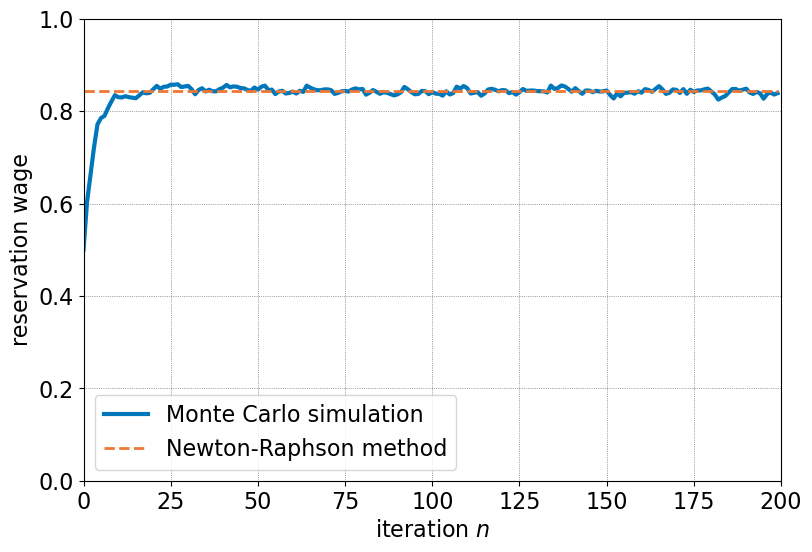

In [7]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,i], 'ylim': [0,1],
         'xlabel': 'iteration $n$', 'ylabel': 'reservation wage',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

print('Plotting the reservation wage as a function of the variance of the offer distribution.')
fig,ax = ec.GenerateTSPlot(param)

ax.plot(np.linspace(0,i-1,i),wbar_path,linewidth=3,color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='Monte Carlo simulation');
ax.plot(np.linspace(0,i-1,i),np.zeros(i)+wbar,linewidth=2,color=ec.tolColor['tolVibrantOrange'],linestyle='dashed',label='Newton-Raphson method');

x = ax.legend(loc="lower left")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + 'search_mccall_monte_carlo.pdf',bbox_inches='tight')